In [58]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [59]:
import numpy as np
import pandas as pd

In [60]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Inspect data
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [32]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

2016-08-23 00:00:00


<function matplotlib.pyplot.show(*args, **kw)>

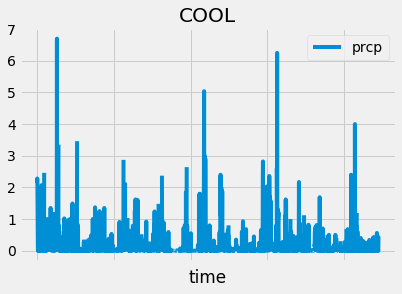

In [312]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
yearago = dt.datetime(2017,8,23)-dt.timedelta(days=365)
print(yearago)

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
twelve = session.query(*sel).filter(Measurement.date>yearago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(twelve,columns=['time','prcp'])
df= df.set_index('time')
df = df.sort_values(by="time",ascending=True)

# Sort the dataframe by date

df.head(20) #already sorted by date

# Use Pandas Plotting with Matplotlib to plot the data

ax = df.plot(title='COOL')
plt.show

![precipitation](Images/precipitation.png)

In [349]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,id,temp
count,356.000000,356.000000
mean,14781.500000,73.176966
std,102.912584,4.752420
min,14604.000000,59.000000
25%,14692.750000,70.000000
50%,14781.500000,74.000000
75%,14870.250000,77.000000
max,14959.000000,83.000000


![describe](Images/describe.png)

In [225]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station.station).count()
count

9

In [226]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [245]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count2 = session.query(Measurement.id,Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
count2

[(12188, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2725, 'USC00513117', 2709),
 (9519, 'USC00519523', 2669),
 (16939, 'USC00516128', 2612),
 (5434, 'USC00514830', 2202),
 (14960, 'USC00511918', 1979),
 (7636, 'USC00517948', 1372),
 (9008, 'USC00518838', 511)]

In [244]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
count2 = session.query(Measurement.id,Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
count2

#how to make average a float?

[(14261, 'USC00519281', 54.0, 85.0, 71.66378066378067),
 (213, 'USC00519397', 56.0, 87.0, 74.55323054331865),
 (4412, 'USC00513117', 59.0, 85.0, 72.68918420081211),
 (12184, 'USC00519523', 56.0, 85.0, 74.5436493068565),
 (18245, 'USC00516128', 58.0, 84.0, 70.91500765696784),
 (7017, 'USC00514830', 58.0, 85.0, 74.8732970027248),
 (15210, 'USC00511918', 53.0, 87.0, 71.61596766043456),
 (8991, 'USC00517948', 58.0, 87.0, 74.68440233236151),
 (9190, 'USC00518838', 58.0, 83.0, 72.72407045009784)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 54., 31.,  9.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

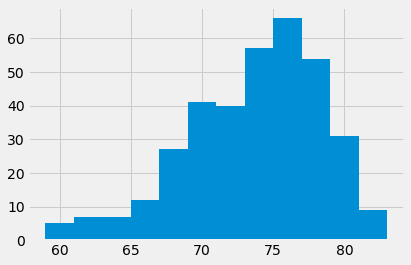

In [314]:
# Choose the station with the highest number of temperature observations. = 12188 USC 00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

top = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()
yearago = dt.datetime(2017,8,18)-dt.timedelta(days=365)

sel = [Measurement.date, Measurement.id, Measurement.tobs]
temp = session.query(*sel).filter(Measurement.date>yearago).filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()
df = pd.DataFrame(temp,columns=['date','id','temp'])
plt.hist(df['temp'],bins=12)

![precipitation](Images/station-histogram.png)

In [287]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [331]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-30'))

start_date = dt.datetime(2017,1,1)-dt.timedelta(days=365)
end_date = dt.datetime(2017,1,30)-dt.timedelta(days=365)

yearago = calc_temps(start_date,end_date)
tmin = yearago[0][0]
tavg = yearago[0][1]
tmax = yearago[0][2]

[(60.0, 69.7445652173913, 81.0)]


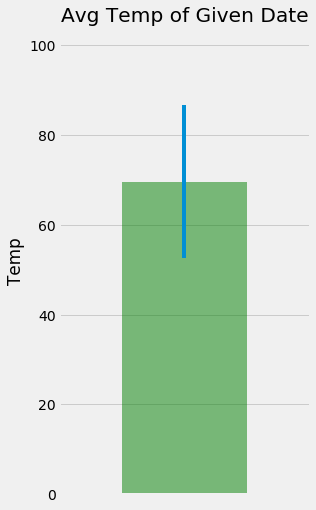

In [348]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
y = tmax-tmin
bar = ax.bar(xpos, tavg,alpha = 0.5, color = 'green', align = "center")
ax.errorbar(xpos,tavg,yerr=tmax-tmin)
ax.set(xticks = range(xpos), xticklabels = "a", title = "Avg Temp of Given Date", ylabel = "Temp")
ax.margins(.5, .2)
fig.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
